# Kaggle Competition - Titanic: Machine Learning from Disaster

The aim of this notebook is to build a model to predict the survival of passengers of the Titanic. We'll work with data from the [Kaggle *Titanic: Machine Learning from Disaster*](https://www.kaggle.com/c/titanic) competition, starting with an exploration and visualisation of the provided features. After that we'll build a feature engineering pipeline using [scikit-learn](https://scikit-learn.org/stable/index.html)'s Pipeline class. Finally we'll use several machine learning approaches to solve the prediction problem.

## The Problem

* **Objective**: Predict if a passenger survived the sinking of the Titanic or not.
* **Problem Frame**: This is a supervised, offline, binary classification problem.
* **Performance Metric**:  *Accuracy*, i.e. the percentage of correctly classified passengers.

## Magics & Imports

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
# We use autoreloading of changed modules.
%reload_ext autoreload
%autoreload 2

In [2]:
# Import libraries for data science
import numpy as np
import pandas as pd

# Import libraries for plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

# Import libraries for working with paths
from pathlib import Path
from collections import defaultdict, Counter
import os

from sklearn.pipeline import make_pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import *
from sklearn.metrics import *

from mltools.dirtools import show_dir_contents
from mltools.io import get_data_from_csvs
from mltools.feature_exploration import *

## Getting the Data
* **Dataset**: Titanic Dataset provided by the competion.

In [3]:
# Define path to the dataset-directory, here we assume it to be in 'local_data' folder:
titanic_data_path = Path('./local_data/titanic')

In [4]:
show_dir_contents(titanic_data_path)

Contents of 'local_data\titanic':

Name                      Length (kB)
----                      -----------
gender_submission.csv     3
test.csv                  28
test_predictions.csv      3
train.csv                 60


In [5]:
# Define train and test-data file paths:
train_data_path = titanic_data_path / 'train.csv'
test_data_path = titanic_data_path / 'test.csv'

df_train_raw, df_test_raw = get_data_from_csvs(train_data_path, test_data_path)

## Exploring the Data

### Basics

In [6]:
# We print the dimensions of the training and test set and show the first rows of the training set
print('Training data set: {}, Test data set {}'.format(df_train_raw.shape, df_test_raw.shape))
df_train_raw.head()

Training data set: (891, 12), Test data set (418, 11)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [7]:
# Print some basic information about the training set:
descr_dict = {
    "Name": "name of the passenger",
    "PassengerId": "identification number of passenger",
    "Survived": "0 = No, 1 = Yes",
    "Pclass": "1 = 1st, 2 = 2nd, 3 = 3rd",
    "Sex": "female, male",
    "Age": "in years",
    "SibSp": "nr of siblings/spouses aboard the Titanic",
    "Parch": "nr of parents/children aboard the Titanic",
    "Ticket": "ticket number",
    "Fare": "passenger fare",
    "Cabin": "cabin number",
    "Embarked": "port of embarkation: C = Cherbourg, Q = Queenstown, S = Southampton"
}

df_train_info = extended_info(df_train_raw, descr_dict)
df_test_info = extended_info(df_test_raw, descr_dict)

with pd.option_context('display.max_colwidth', -1):
    print("Training set:")
    display(df_train_info)
    print("Test set:")
    display(df_test_info)

Training set:


,type,non-null,nunique,description
PassengerId,int64,891,891,identification number of passenger
Survived,int64,891,2,"0 = No, 1 = Yes"
Pclass,int64,891,3,"1 = 1st, 2 = 2nd, 3 = 3rd"
Name,object,891,891,name of the passenger
Sex,object,891,2,"female, male"
Age,float64,714,88,in years
SibSp,int64,891,7,nr of siblings/spouses aboard the Titanic
Parch,int64,891,7,nr of parents/children aboard the Titanic
Ticket,object,891,681,ticket number
Fare,float64,891,248,passenger fare


Test set:


,type,non-null,nunique,description
PassengerId,int64,418,418,identification number of passenger
Pclass,int64,418,3,"1 = 1st, 2 = 2nd, 3 = 3rd"
Name,object,418,418,name of the passenger
Sex,object,418,2,"female, male"
Age,float64,332,79,in years
SibSp,int64,418,7,nr of siblings/spouses aboard the Titanic
Parch,int64,418,8,nr of parents/children aboard the Titanic
Ticket,object,418,363,ticket number
Fare,float64,417,169,passenger fare
Cabin,object,91,76,cabin number


**Observations**: 
- We can see that the PassengerId column contains as many unique values as there are rows,
so we'll take this column as the index-column of the dataframe.
- All names are unique and without further feature engineering probably won't be useful for the classification.
- Age, Cabin and Embarked have missing values in the training and test sets, additionally there is one missing Fare value in the test set.
- Ticket has no missing values but contains many duplicates, which could mean that some passengers travelled with the same ticket number (e.g.: very young children with their parents tickets) or these are errors in the data.

In [8]:
df_train_raw.set_index('PassengerId', inplace=True)
df_test_raw.set_index('PassengerId', inplace=True)
df_train_raw.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [9]:
# Show statistics of the numerical features:
df_train_raw.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


**Observations**: 
- We can see that about 38% of passengers in the training set survived. 
- It seems that for children below the age 1, floating point numbers were used to indicate the fraction of the year.
(min = 0.42)
- 50% of the passengers were younger than 28, 75% younger than 38, then overall mean age was ~30.
- 75% of passengers travelled with 1 or less siblings or spouse.
- Most passengers travelled alone.
- 75% of the passenger's fare price was below 31$

### Linear and monotonic Correlations

In [10]:
# Show linear correlations of numerical features with the target.
print("Pearson Correlation:")
display(show_corr(df_train_raw, target_name="Survived", method="pearson"))
print("Spearman Correlation:")
display(show_corr(df_train_raw, target_name="Survived", method="spearman"))

Pearson Correlation:


,Survived
Survived,1.0
Fare,0.26
Parch,0.082
SibSp,-0.035
Age,-0.077
Pclass,-0.34


Spearman Correlation:


,Survived
Survived,1.0
Fare,0.32
Parch,0.14
SibSp,0.089
Age,-0.053
Pclass,-0.34


**Observations:**
* The features *Fare* and *Pclass* show a slight linear (Pearson) and monotonic (Spearman) correlation with the target feature.
  The spearman correlation coefficient is larger than the pearson coefficient for *Fare*, therefore we might try applying a non-linear transform to this feature.

In [11]:
df_train = df_train_raw.copy()
df_train["Fare"] = np.log(df_train["Fare"] + 1)

In [12]:
show_corr(df_train, "Survived", "pearson")

,Survived
Survived,1.0
Fare,0.33
Parch,0.082
SibSp,-0.035
Age,-0.077
Pclass,-0.34


### Correlation Matrix

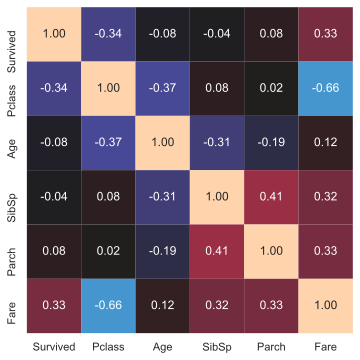

In [13]:
_, ax = plt.subplots(figsize=(6, 6))
sns.heatmap(df_train.corr(), square=True, vmin=-1.0, vmax=1.0, annot=True, fmt=".2f", cbar=False, ax=ax, center= 0)
plt.show()

**Observations**:
* We can see a quite strong linear inverse correlation between *Pclass* and *Fare*, which is expected as ticket prices decrease as the class number increases.

### Numerical and non-numerical Features

In [14]:
# Show numerical and non-numerical features.
feature_types = get_feature_types(df_train)
feature_types

{'numerical': ['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare'],
 'non_numerical': ['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']}

In [15]:
df_train[feature_types["numerical"]].nunique()

Survived      2
Pclass        3
Age          88
SibSp         7
Parch         7
Fare        248
dtype: int64

**Observations**: 
- 'Pclass', 'SibSp' and 'Parch' each only take on a small number of different values.

In [16]:
df_train[feature_types["non_numerical"]].nunique()

Name        891
Sex           2
Ticket      681
Cabin       147
Embarked      3
dtype: int64

In [17]:
# We can transform the non-numerical feature's datatypes to categorical.
df_train[feature_types["non_numerical"]] = df_train[feature_types["non_numerical"]].astype("category")

In [18]:
df_train.describe(include=["category"])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"van Melkebeke, Mr. Philemon",male,CA. 2343,B96 B98,S
freq,1,577,7,4,644


### Visualization

#### Charts for categorical features
- Pclass
- Sex
- SibSp ( # of siblings and spouse)
- Parch ( # of parents and children)
- Embarked
- Cabin

In [19]:
def visualize_feature(df, feature, figsize=(12, 6)):
    fig, axes = plt.subplots(ncols=2, figsize=figsize)
    count_plot = sns.countplot(x="Survived", data=df, hue=feature, ax=axes[0])
    count_plot.set_xticklabels(["no", "yes"])
    count_plot.set_ylabel("Nr of Passengers")
    count_plot.legend(loc="upper right")
    sns.barplot(x=feature, y="Survived", data=df, ax=axes[1]).set_ylabel("Survival Rate")
    
    title = "Survival by feature \"{}\" ({})".format(feature, df_train_info.loc[feature]["description"]) if feature in df_train_info.index else f"Survival by feature \"{feature}\""
    fig.suptitle(title)
    plt.show()

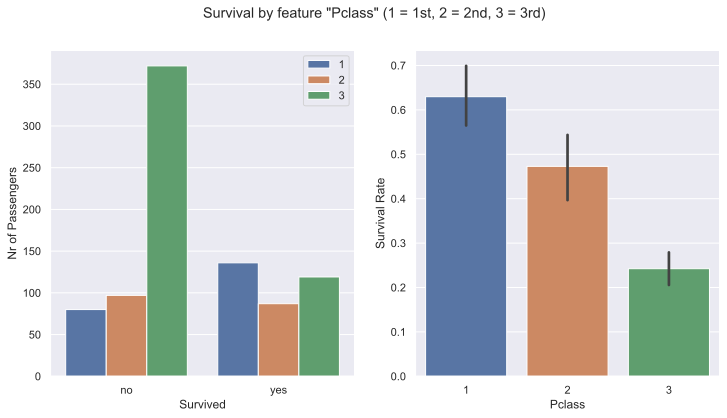

In [20]:
visualize_feature(df_train, "Pclass")

We see that **1st class** passengers were more likely to survive than the other classes.
The **3rd class passengers** were more likely to die than all other classes.

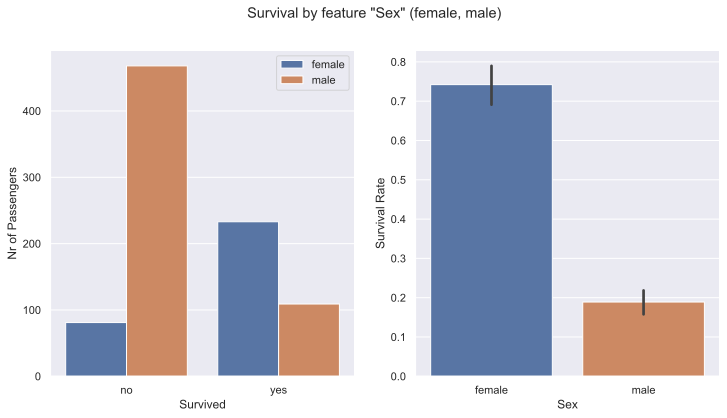

In [21]:
visualize_feature(df_train, "Sex")

We see that **women** were far more likely to survive than **men**.

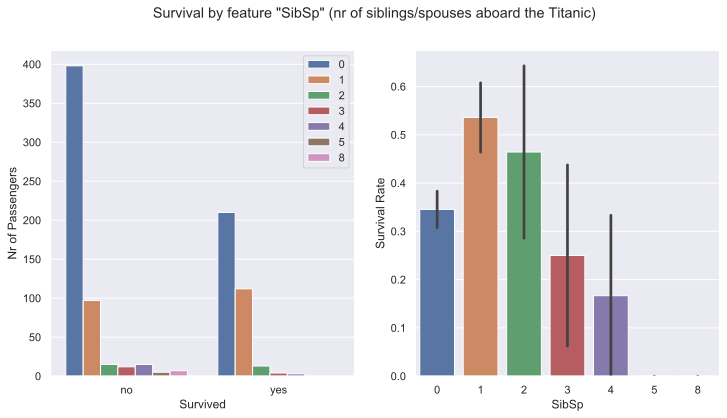

In [22]:
visualize_feature(df_train, "SibSp")

Evidently, the proportion of passengers with **1 or 2 siblings/spouses** who survived is larger than those with more or less siblings/spouses.

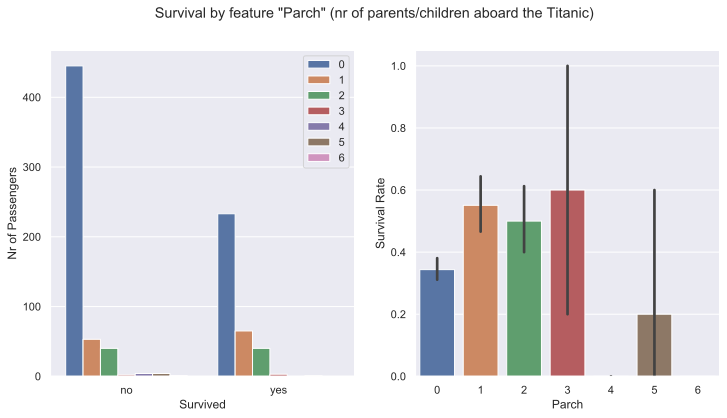

In [23]:
visualize_feature(df_train, "Parch")

Evidently, the proportion of passengers with **1 to 3 parents/children** who survived is larger than those who had more or less. 
The last two feature plots show that from the passengers who died, a large portion was travelling alone.

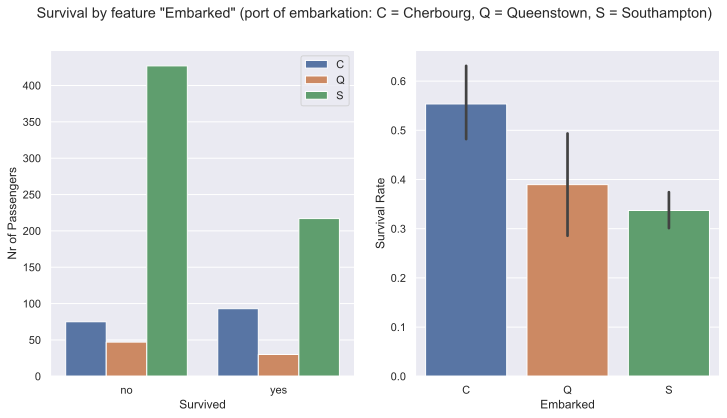

In [24]:
visualize_feature(df_train, "Embarked")

Passengers from **Cherbourg** were more likely to survive then those embarking from the other cities.

In [25]:
# The first letter in the Cabin feature seems to be name of the deck:
df_train["Deck"] = df_train["Cabin"].str[0]
df_train["Deck"] = df_train["Deck"].astype("category")

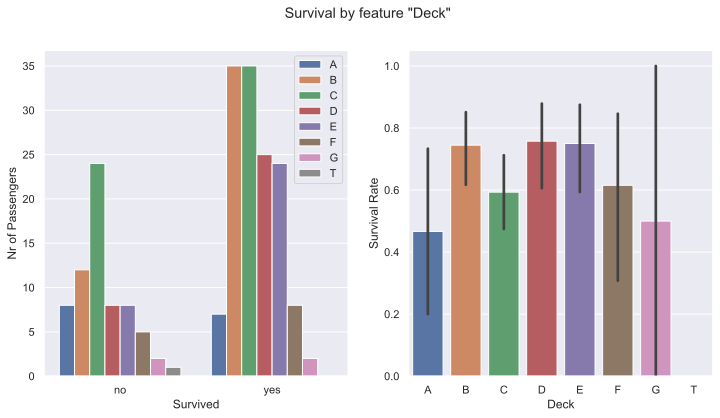

In [26]:
visualize_feature(df_train, "Deck")

Passengers whose *Cabin* feature starts with B, C, D, E, F were more likely to survive.

## Building a Feature Engineering Pipeline

In [27]:
X_raw = df_train_raw.drop("Survived", axis=1)
y_raw = df_train_raw["Survived"]

### Adding new Features

In [28]:
from sklearn.base import BaseEstimator, TransformerMixin

# Our class for adding features:
class FeatureAdder(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.ticket_freq_dict = None
    
    def fit(self, X, y=None):
        self.ticket_freq_dict = defaultdict(int, X["Ticket"].value_counts().to_dict())
        return self
    
    def transform(self, X):
        # Add a titles feature
        X_new = X.copy()
        X_new["Title"] = X_new["Name"].str.extract(' ([A-Za-z]+)\.', expand=False)
        # Add a family size feature
        X_new["FamilySize"] = X_new["SibSp"] + X_new["Parch"] + 1
        # Add deck feature
        X_new["Deck"] = X_new["Cabin"].str[0]
        X_new["AgeBucket"] = pd.cut(X_new["Age"], [0, 15, 30, 45, 60, 75, 90])
        X_new["NumWordsName"] = X_new["Name"].str.split().apply(lambda x: len(x))
        X_new["LogPOFare"] = np.log(X_new["Fare"] + 1)
        
        #X_new["Group"] = X_new["Name"].str.split(",").str.get(0)
        #X_new.loc[X_new.groupby(["Group"])["Group"].transform("count") == 1, "Group"] = "Single"

        ticket_freq = Counter(self.ticket_freq_dict) + Counter(defaultdict(int, X_new["Ticket"].value_counts().to_dict()))
        total = sum(ticket_freq.values(), 0.0)
        
        for key in ticket_freq:
            ticket_freq[key] /= total
        
        X_new["Ticket_Freq"] = X_new["Ticket"].map(ticket_freq)
            
        return X_new

In [29]:
feature_pipeline = make_pipeline(FeatureAdder())

feature_pipeline.fit_transform(X_raw).head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,FamilySize,Deck,AgeBucket,NumWordsName,LogPOFare,Ticket_Freq
PassengerId,,,,,,,,,,,,,,,,,
1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,2,NaN,"(15, 30]",4,2.110213,0.001122
2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,2,C,"(30, 45]",7,4.280593,0.001122
3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,1,NaN,"(15, 30]",3,2.188856,0.001122
4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,2,C,"(30, 45]",7,3.990834,0.002245
5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,1,NaN,"(30, 45]",4,2.202765,0.001122


### Removing Features

In [30]:
# Decide which features to remove:
to_remove = ['Name', 'Fare', 'SibSp', 'Parch', 'Ticket', 'Cabin', 'Age']

class FeatureRemover(BaseEstimator, TransformerMixin):
    def __init__(self, to_remove):
        self.to_remove=to_remove
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.drop(self.to_remove, axis=1)

In [31]:
feature_pipeline = make_pipeline(FeatureAdder(), FeatureRemover(to_remove))

feature_pipeline.fit_transform(X_raw).head()

,Pclass,Sex,Embarked,Title,FamilySize,Deck,AgeBucket,NumWordsName,LogPOFare,Ticket_Freq
PassengerId,,,,,,,,,,
1,3,male,S,Mr,2,NaN,"(15, 30]",4,2.110213,0.001122
2,1,female,C,Mrs,2,C,"(30, 45]",7,4.280593,0.001122
3,3,female,S,Miss,1,NaN,"(15, 30]",3,2.188856,0.001122
4,1,female,S,Mrs,2,C,"(30, 45]",7,3.990834,0.002245
5,3,male,S,Mr,1,NaN,"(30, 45]",4,2.202765,0.001122


### Handling missing Data

In [32]:
class FeatureAddMissing(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        # Missing ages will be replace by the median of the corresponding Title group
        self.age_bucket_medians = X.groupby("Title")["AgeBucket"].apply(lambda x: X["AgeBucket"].cat.categories[int(x.cat.codes.median())])
        self.log_fare_medians = X.groupby("Pclass")["LogPOFare"].median()
        self.embarked_val = X["Embarked"].value_counts().idxmax()
        self.deck_val = 'N'
        return self
    
    def transform(self, X):
        Xnew = X.copy()
        Xnew.loc[Xnew['AgeBucket'].isnull(), "AgeBucket"] = Xnew.loc[Xnew["AgeBucket"].isnull(), "Title"].map(self.age_bucket_medians)
        Xnew.loc[Xnew['LogPOFare'].isnull(), "LogPOFare"] = Xnew.loc[Xnew["LogPOFare"].isnull(), "Pclass"].map(self.log_fare_medians)
        Xnew['Embarked'].fillna(self.embarked_val, inplace=True)
        Xnew['Deck'].fillna(self.deck_val, inplace=True)
        return Xnew

In [33]:
feature_pipeline = make_pipeline(FeatureAdder(), FeatureRemover(to_remove), FeatureAddMissing())

extended_info(feature_pipeline.fit_transform(X_raw))

,type,non-null,nunique
Pclass,int64,891,3
Sex,object,891,2
Embarked,object,891,3
Title,object,891,17
FamilySize,int64,891,9
Deck,object,891,9
AgeBucket,category,891,6
NumWordsName,int64,891,8
LogPOFare,float64,891,248
Ticket_Freq,float64,891,7


### Changing Object Types to Category

In [34]:
# Our class for adding features:
class Categorizer(BaseEstimator, TransformerMixin):
    def __init__(self, categories=None):
        self.categories = categories
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_new = X.copy()
        
        if self.categories is not None and self.categories:
            X_new[self.categories] = X_new[self.categories].astype("category")
        else:
            X_new[X_new.select_dtypes("object").columns] = X_new.select_dtypes("object").astype("category")
        
        return X_new

In [35]:
feature_pipeline = make_pipeline(FeatureAdder(), FeatureRemover(to_remove), FeatureAddMissing(), Categorizer())

feature_pipeline.fit_transform(df_train_raw)["Title"].value_counts()

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Col           2
Mlle          2
Major         2
Countess      1
Don           1
Sir           1
Jonkheer      1
Lady          1
Mme           1
Ms            1
Capt          1
Name: Title, dtype: int64

**Observation**:
* Most of the Titles occur very rarely, therefore we will combine some of them in the following section.

### Clip Categories

In [36]:
# Our class for adding features:
class CategoryMaxClipper(BaseEstimator, TransformerMixin):
    def __init__(self, categories, max_values=4):
        if isinstance(max_values, list):
            assert len(max_values) == len(categories)
            self.max_values = max_values
        elif isinstance(max_values, int):
            self.max_values = [max_values] * len(categories)
        else:
            raise ValueError("max_values must be either an int or a list of ints.")
   
        self.categories = categories
    
    def fit(self, X, y=None):
        self.maps = {category: defaultdict(lambda: max_val, {cat_name: code for code, (cat_name, _) in enumerate(X[category].value_counts().iloc[:max_val].items())}) 
                     for max_val, category in zip(self.max_values, self.categories)}
        return self
    
    def transform(self, X):
        X_new = X.copy()
        for category in self.categories:
            X_new[category] = X_new[category].map(self.maps[category])
        return X_new

In [37]:
feature_pipeline = make_pipeline(
    FeatureAdder(), 
    FeatureRemover(to_remove), 
    FeatureAddMissing(), 
    Categorizer(), 
    CategoryMaxClipper(["Title"])
)

feature_pipeline.fit_transform(X_raw).head()

,Pclass,Sex,Embarked,Title,FamilySize,Deck,AgeBucket,NumWordsName,LogPOFare,Ticket_Freq
PassengerId,,,,,,,,,,
1,3,male,S,0,2,N,"(15, 30]",4,2.110213,0.001122
2,1,female,C,2,2,C,"(30, 45]",7,4.280593,0.001122
3,3,female,S,1,1,N,"(15, 30]",3,2.188856,0.001122
4,1,female,S,2,2,C,"(30, 45]",7,3.990834,0.002245
5,3,male,S,0,1,N,"(30, 45]",4,2.202765,0.001122


### Encode Categories

In [38]:
# Our class for adding features:
class CategoryEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.code_to_cat_ = {} 
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_new = X.copy()
        
        for col in X_new.select_dtypes("category").columns:
            self.code_to_cat_[col] = dict(enumerate(X_new[col].cat.categories))
            X_new[col] = X_new[col].cat.codes
        
        return X_new

In [39]:
feature_pipeline = make_pipeline(
    FeatureAdder(), 
    FeatureRemover(to_remove), 
    FeatureAddMissing(), 
    Categorizer(), 
    CategoryMaxClipper(["Title"]),
    CategoryEncoder()
)

X_train_cat_encoded = feature_pipeline.fit_transform(X_raw)
X_train_cat_encoded.head()

,Pclass,Sex,Embarked,Title,FamilySize,Deck,AgeBucket,NumWordsName,LogPOFare,Ticket_Freq
PassengerId,,,,,,,,,,
1,3,1,2,0,2,7,1,4,2.110213,0.001122
2,1,0,0,2,2,2,2,7,4.280593,0.001122
3,3,0,2,1,1,7,1,3,2.188856,0.001122
4,1,0,2,2,2,2,2,7,3.990834,0.002245
5,3,1,2,0,1,7,2,4,2.202765,0.001122


### OneHotEncoding

In [40]:
one_hot_encoded_features = ["Embarked", "Title", "Deck"]
all_encoded_features = X_train_cat_encoded.columns

feature_pipeline = make_pipeline(
    FeatureAdder(), 
    FeatureRemover(to_remove), 
    FeatureAddMissing(), 
    Categorizer(), 
    CategoryMaxClipper(["Title"]),
    CategoryEncoder(),
    ColumnTransformer([("onehotencoding", OneHotEncoder(categories="auto", handle_unknown="ignore", sparse=False), one_hot_encoded_features)], remainder="passthrough")
)

feature_pipeline.fit_transform(X_raw)

array([[0.00000000e+00, 0.00000000e+00, 1.00000000e+00, ...,
        4.00000000e+00, 2.11021320e+00, 1.12233446e-03],
       [1.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        7.00000000e+00, 4.28059312e+00, 1.12233446e-03],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00, ...,
        3.00000000e+00, 2.18885633e+00, 1.12233446e-03],
       ...,
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00, ...,
        5.00000000e+00, 3.19663022e+00, 2.24466891e-03],
       [1.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        4.00000000e+00, 3.43398720e+00, 1.12233446e-03],
       [0.00000000e+00, 1.00000000e+00, 0.00000000e+00, ...,
        3.00000000e+00, 2.16905370e+00, 1.12233446e-03]])

### Scaling

In [41]:
feature_pipeline = make_pipeline(
    FeatureAdder(), 
    FeatureRemover(to_remove), 
    FeatureAddMissing(), 
    Categorizer(), 
    CategoryMaxClipper(["Title"]),
    CategoryEncoder(),
    ColumnTransformer([("onehotencoding", OneHotEncoder(categories="auto", handle_unknown="ignore", sparse=False), one_hot_encoded_features)], remainder="passthrough"),
    StandardScaler()
)

feature_pipeline.fit_transform(X_raw)

array([[-0.48204268, -0.30756234,  0.61583843, ..., -0.05764383,
        -0.87974057, -0.57916179],
       [ 2.0745051 , -0.30756234, -1.62380254, ...,  2.51038878,
         1.36121993, -0.57916179],
       [-0.48204268, -0.30756234,  0.61583843, ..., -0.9136547 ,
        -0.79853997, -0.57916179],
       ...,
       [-0.48204268, -0.30756234,  0.61583843, ...,  0.79836704,
         0.24200664,  0.15592818],
       [ 2.0745051 , -0.30756234, -1.62380254, ..., -0.05764383,
         0.48708246, -0.57916179],
       [-0.48204268,  3.25137334, -1.62380254, ..., -0.9136547 ,
        -0.81898658, -0.57916179]])

## Modelling

### Split Training and Validation Sets

In [42]:
X_train_raw, X_val_raw, y_train, y_val = train_test_split(X_raw, y_raw, test_size=0.20, random_state=42, stratify=y_raw)

In [43]:
X_train = feature_pipeline.fit_transform(X_train_raw)
X_val = feature_pipeline.transform(X_val_raw)

### Define some useful Functions

In [44]:
def fit_and_score(model, X_train=X_train_raw, y_train=y_train, X_val=X_val_raw, y_val=y_val, feature_pipeline=feature_pipeline):
    clf = make_pipeline(feature_pipeline, model)
    clf.fit(X_train, y_train)
    print("Accuracy scores - Train: {0:.4}, Val: {1:.4}".format(clf.score(X_train, y_train), clf.score(X_val, y_val)))
    
def print_cross_val_scores(model, X=X_train_raw, y=y_train, feature_pipeline=feature_pipeline, cv=5):
    clf = make_pipeline(feature_pipeline, model)
    cv_scores = cross_val_score(clf, X=X, y=y, cv=cv)
    print(f"{cv}-fold cross-val mean-accuracy score: {cv_scores.mean():.4}")
    
def plot_roc_curve(fpr, tpr, thresholds, ax, title):
    ax.plot(fpr, tpr, label="ROC curve (area = {0:.2f})".format(auc(fpr, tpr)))
    ax.plot([0, 1], [0, 1], linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.0])
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title(title)
    ax.axis("square")
    ax.legend(loc="lower right")
    
def plot_recall_precision_curve(recalls, precisions, ax, title):
    ax.plot(recalls[:-1], precisions[:-1])
    ax.set_title(title)
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.0])
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.axis("square")
    
def show_scores(model, X_train=X_train_raw, y_train=y_train, X_val=X_val_raw, y_val=y_val, feature_pipeline=feature_pipeline, cv=5, show_roc_curves=True):
    clf = make_pipeline(feature_pipeline, model)
    clf.fit(X_train, y_train)
    
    y_train_pred = clf.predict(X_train)
    y_train_pos_proba = clf.predict_proba(X_train)[:, 1]
    y_val_pred = clf.predict(X_val)
    y_val_pos_proba = clf.predict_proba(X_val)[:, 1]
    
    scores = []
    
    for true, pred, proba in [(y_train, y_train_pred, y_train_pos_proba), (y_val, y_val_pred, y_val_pos_proba)]:
        scores.append({"Accuracy": accuracy_score(true, pred), "Precision": precision_score(true, pred), "Recall": recall_score(true, pred), "F1": f1_score(true, pred), "ROC AUC": roc_auc_score(true, proba)})
    
    cv_scores = cross_validate(clf, X=X_train, y=y_train, cv=cv, scoring=["accuracy", "precision", "recall", "f1", "roc_auc"])
    
    scores.append({"Accuracy": cv_scores["test_accuracy"].mean(), "Precision": cv_scores["test_precision"].mean(), "Recall": cv_scores["test_recall"].mean(), "F1": cv_scores["test_f1"].mean(), "ROC AUC": cv_scores["test_roc_auc"].mean()})
    
    if show_roc_curves:
        _, ax = plt.subplots(ncols=2, figsize=(10, 5))

        fpr, tpr, thresholds = roc_curve(y_train, y_train_pos_proba)
        plot_roc_curve(fpr, tpr, thresholds, ax=ax[0], title="Train")

        fpr, tpr, thresholds = roc_curve(y_val, y_val_pos_proba)
        plot_roc_curve(fpr, tpr, thresholds, ax=ax[1], title="Val")

        plt.show()

    return pd.DataFrame(scores, index=["Train", "Validation", f"Train {cv}-fold CV (means)"])

def show_validation_curve(model, param_name, param_range, X=X_train_raw, y=y_train, feature_pipeline=feature_pipeline, cv=5, scoring="f1", ax=None):
    clf = make_pipeline(feature_pipeline, model)
    
    clf_param_name = model.__class__.__name__.lower() + "__" + param_name
    
    # Adapted from: https://scikit-learn.org/stable/auto_examples/model_selection/plot_validation_curve.html
    train_scores, test_scores = validation_curve(clf, X=X, y=y, cv=cv, param_name=clf_param_name, param_range=param_range, scoring=scoring)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    cv_opt_x = param_range[np.argmax(test_scores_mean)]
    cv_opt_y = np.max(test_scores_mean)
    
    do_show = False
    
    if ax is None:
        _, ax = plt.subplots(figsize=(7, 7))
        do_show = True
        
    ax.set_title(f"Validation Curve ({scoring})")
    ax.set_xlabel(param_name)
    ax.set_ylabel(scoring)
    ax.semilogx(param_range, train_scores_mean, label="Train")
    ax.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2)
    ax.semilogx(param_range, test_scores_mean, label=f"{cv}-fold CV (mean)")
    ax.fill_between(param_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.2)
    ax.axvline(x=cv_opt_x, lw=1, alpha=0.2, color="red")
    ax.axhline(y=cv_opt_y, lw=1, alpha=0.2, color="red")
    ax.plot(cv_opt_x, cv_opt_y, marker='o', markersize=3, color="red", label="CV-opt: ({0:.4f}, {1:.2f})".format(float(cv_opt_x), cv_opt_y))
    ax.legend()
    
    if do_show:
        plt.show()
    
def grid_search_results_df(model, gs, refit):
    results = gs.cv_results_
    df = pd.DataFrame(results).filter(regex="^(mean_test|param_)").sort_values(by=["mean_test_" + refit], ascending=False) 
    param_cols = df.columns.str.find("__");
    param_col_rename = {col_name: col_name[start_index + 2:] for col_name, start_index in zip(df.columns, param_cols) if start_index != -1 }
    df.rename(columns=param_col_rename, inplace=True);        
    return df  

def plot_grid_search_results_df(results_df, numeric_col, cat_col, cat_names=None): 
    unique_categories = results_df[cat_col].unique() if cat_names is None else cat_names
        
    _, ax = plt.subplots(ncols=len(unique_categories), figsize=(len(unique_categories) * 7, 5), squeeze=False)
    
    df = results_df.sort_values(by=numeric_col)
    
    for i, cat in enumerate(unique_categories):
        df.loc[df[cat_col] == cat, df.columns.str.match(f"^(mean_test_|{numeric_col})")].plot(x=numeric_col, ax=ax[0][i], title=f"{cat_col}={cat}")
    plt.show()
    
def grid_search(model, params, X=X_train_raw, y=y_train, feature_pipeline=feature_pipeline, cv=5, refit="f1", verbose=1,  n_jobs=1, randomized=False, **grid_search_params):
    clf = make_pipeline(feature_pipeline, model)
    
    clf_param_name_prefix = model.__class__.__name__.lower() + "__"
    scoring = ["accuracy", "precision", "recall", "f1", "roc_auc"] 

    if randomized:
        clf_params = {clf_param_name_prefix + param: values for param, values in params.items()}
        gs_cv = RandomizedSearchCV(clf, clf_params, cv=cv, scoring=scoring, refit=refit, verbose=verbose, n_jobs=n_jobs, iid=False, **grid_search_params)
    else:
        clf_param_grid = [{clf_param_name_prefix + param: values for param, values in row.items()} for row in params]
        gs_cv = GridSearchCV(clf, clf_param_grid, cv=cv, scoring=scoring, refit=refit, verbose=verbose, n_jobs=n_jobs, iid=False, **grid_search_params)
        
    gs_cv.fit(X, y)
    
    return gs_cv, grid_search_results_df(model, gs_cv, refit)

### Gaussian Naive Bayes

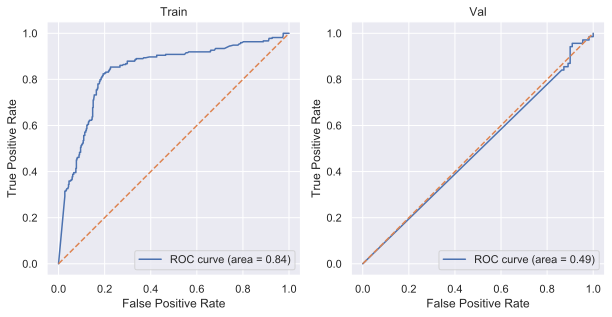

,Accuracy,Precision,Recall,F1,ROC AUC
Train,0.683989,0.553812,0.904762,0.687065,0.838473
Validation,0.385475,0.385475,1.000000,0.556452,0.490514
Train 5-fold CV (means),0.581556,0.510654,0.897845,0.634566,0.739577


In [45]:
from sklearn.naive_bayes import GaussianNB

gnb_clf = GaussianNB()
show_scores(gnb_clf)

### $k$-Nearest Neighbors

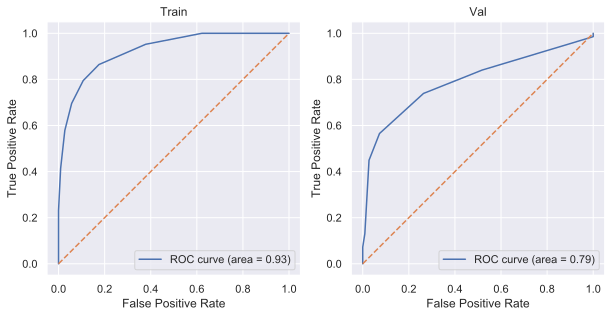

,Accuracy,Precision,Recall,F1,ROC AUC
Train,0.848315,0.883721,0.695971,0.778689,0.925142
Validation,0.787709,0.829787,0.565217,0.672414,0.794730
Train 5-fold CV (means),0.787921,0.782158,0.637643,0.697821,0.852039


In [46]:
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier(n_neighbors=8)
show_scores(knn_clf, show_roc_curves=True)

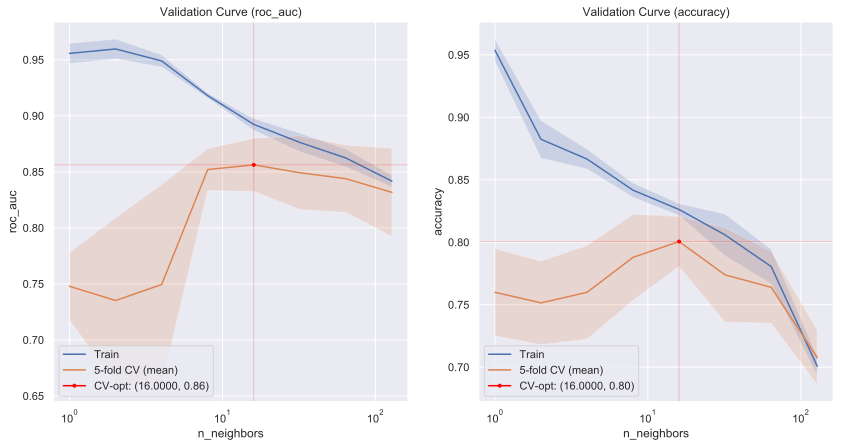

In [47]:
_, ax = plt.subplots(ncols=2, figsize=(14, 7))

show_validation_curve(knn_clf, "n_neighbors", [1, 2, 4, 8, 16, 32, 64, 128], scoring="roc_auc", ax=ax[0])
show_validation_curve(knn_clf, "n_neighbors", [1, 2, 4, 8, 16, 32, 64, 128], scoring="accuracy", ax=ax[1])
plt.show()

In [48]:
knn_gs_param_grid =[
    {"n_neighbors": [1, 2, 4, 8, 16, 32, 64], "weights": ["uniform", "distance"]}
]

knn_gs, knn_gs_df = grid_search(knn_clf, knn_gs_param_grid)

Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:   15.4s finished


In [49]:
knn_gs_df

,n_neighbors,weights,mean_test_accuracy,mean_test_precision,mean_test_recall,mean_test_f1,mean_test_roc_auc
9,16,distance,0.809018,0.768937,0.718249,0.741090,0.867614
7,8,distance,0.794874,0.754509,0.699731,0.723042,0.854130
11,32,distance,0.799149,0.767350,0.685118,0.721024,0.857691
8,16,uniform,0.800577,0.777399,0.678114,0.719858,0.856232
6,8,uniform,0.787921,0.782158,0.637643,0.697821,0.852039
3,2,distance,0.765513,0.708021,0.685051,0.691988,0.786765
0,1,uniform,0.759929,0.690457,0.696094,0.689968,0.747838
1,1,distance,0.759929,0.690457,0.696094,0.689968,0.747838
10,32,uniform,0.773835,0.732266,0.648215,0.684910,0.849187
5,4,distance,0.755723,0.706814,0.652121,0.672704,0.797162


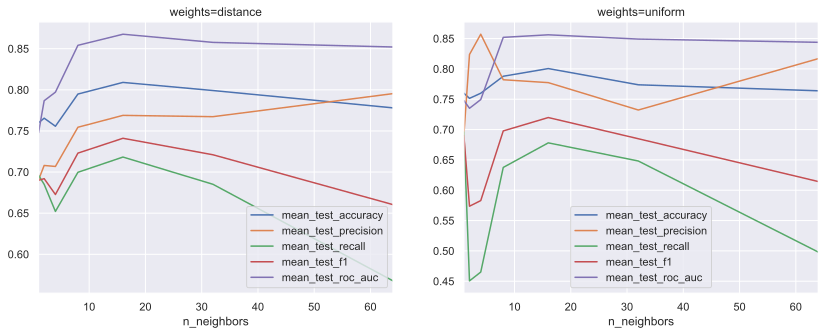

In [50]:
plot_grid_search_results_df(knn_gs_df, "n_neighbors", "weights")

### Logistic Regression

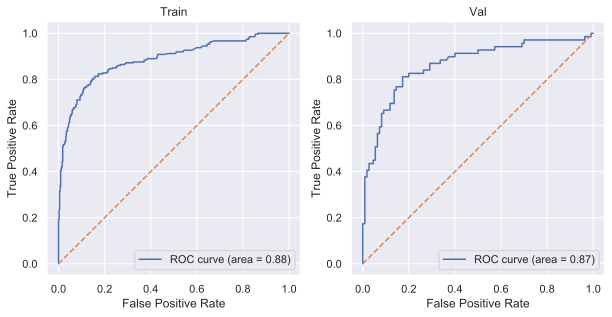

,Accuracy,Precision,Recall,F1,ROC AUC
Train,0.830056,0.777372,0.780220,0.778793,0.884774
Validation,0.810056,0.786885,0.695652,0.738462,0.865020
Train 5-fold CV (means),0.818828,0.778433,0.740135,0.758082,0.857540


In [51]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(C=0.32, solver="liblinear")
show_scores(lr_clf, show_roc_curves=True)

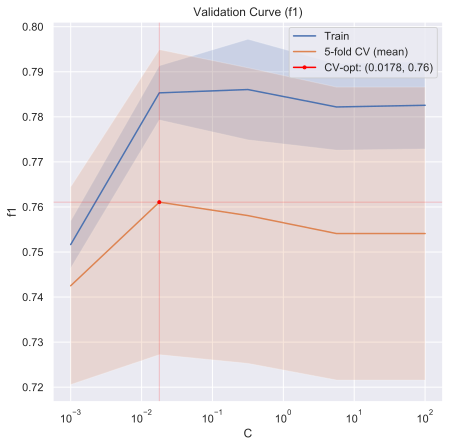

In [52]:
show_validation_curve(lr_clf, "C", np.logspace(-3, 2, 5, endpoint=True))

In [53]:
lr_gs_param_grid =[
    {"C": np.logspace(-2, 2, 6, endpoint=True), "penalty": ["l1", "l2"]}
]

lr_gs, lr_gs_df = grid_search(lr_clf, lr_gs_param_grid)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:   12.5s finished


In [54]:
lr_gs_df

,C,penalty,mean_test_accuracy,mean_test_precision,mean_test_recall,mean_test_f1,mean_test_roc_auc
3,0.0630957,l2,0.823024,0.771552,0.765791,0.767928,0.858014
4,0.398107,l1,0.820256,0.774265,0.751178,0.761986,0.860791
1,0.01,l2,0.804733,0.725803,0.791448,0.755324,0.861929
6,2.51189,l1,0.817410,0.779608,0.732727,0.754924,0.857834
7,2.51189,l2,0.817410,0.782474,0.729091,0.754094,0.857128
8,15.8489,l1,0.817410,0.782474,0.729091,0.754094,0.857298
9,15.8489,l2,0.817410,0.782474,0.729091,0.754094,0.857090
10,100,l1,0.817410,0.782474,0.729091,0.754094,0.857070
11,100,l2,0.817410,0.782474,0.729091,0.754094,0.857028
5,0.398107,l2,0.816001,0.776712,0.732727,0.753463,0.857184


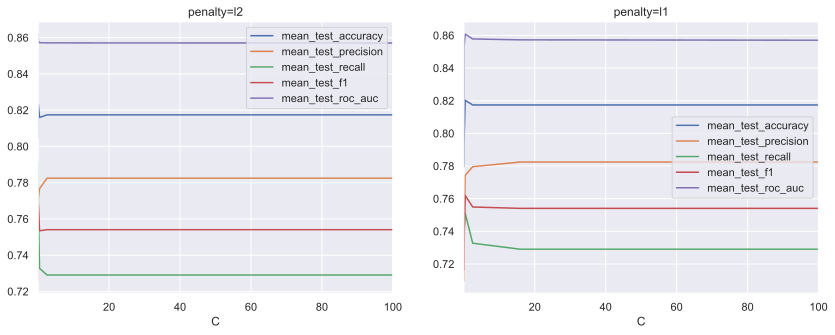

In [55]:
plot_grid_search_results_df(lr_gs_df, "C", "penalty")

### Support Vector Machine

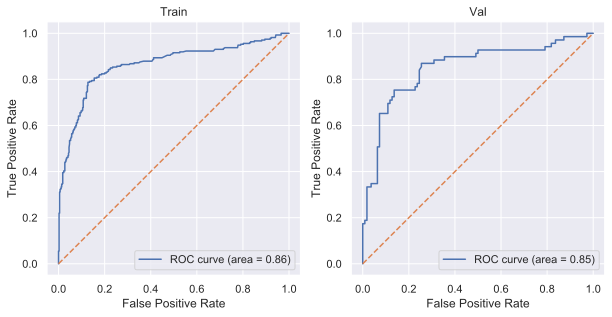

,Accuracy,Precision,Recall,F1,ROC AUC
Train,0.839888,0.793358,0.787546,0.790441,0.863701
Validation,0.821229,0.776119,0.753623,0.764706,0.849341
Train 5-fold CV (means),0.821705,0.778653,0.751178,0.763203,0.844490


In [56]:
from sklearn.svm import SVC

svm_clf = SVC(gamma='scale', kernel="linear", C=0.5, probability=True)
show_scores(svm_clf, show_roc_curves=True)

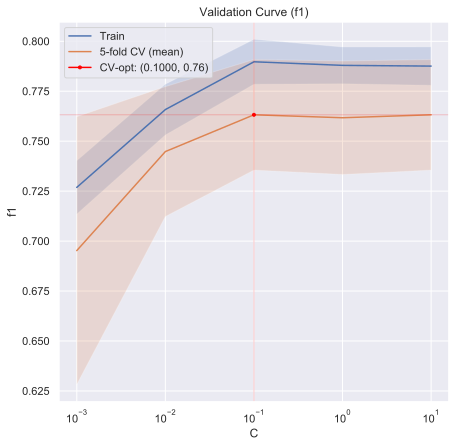

In [57]:
show_validation_curve(svm_clf, "C", np.logspace(-3, 1, 5, endpoint=True))

In [58]:
svm_gs_param_grid =[
    {"C": np.logspace(-1, 1, 5, endpoint=True), "kernel": ["linear"]}, 
    {"C": np.logspace(-1, 1, 5, endpoint=True), "kernel": ["rbf"]}, 
    {"C": np.logspace(-1, 1, 5, endpoint=True), "kernel": ["poly"], "degree": [3, 6, 9]}
]

svm_gs, svm_gs_df = grid_search(svm_clf, svm_gs_param_grid)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:   32.2s finished


In [59]:
svm_gs_df

,C,kernel,degree,mean_test_accuracy,mean_test_precision,mean_test_recall,mean_test_f1,mean_test_roc_auc
0,0.1,linear,NaN,0.821705,0.778653,0.751178,0.763203,0.845730
3,3.16228,linear,NaN,0.821705,0.778653,0.751178,0.763203,0.842900
4,10,linear,NaN,0.821705,0.778653,0.751178,0.763203,0.842735
1,0.316228,linear,NaN,0.821705,0.778653,0.751178,0.763203,0.844405
2,1,linear,NaN,0.820306,0.775138,0.751178,0.761728,0.843280
19,3.16228,poly,3,0.765494,0.728068,0.677441,0.694071,0.804019
6,0.316228,rbf,NaN,0.653242,0.614795,0.857508,0.682635,0.839845
22,10,poly,3,0.759880,0.722987,0.655556,0.679906,0.813001
16,1,poly,3,0.762657,0.740068,0.637172,0.675638,0.804045
7,1,rbf,NaN,0.657408,0.630688,0.824175,0.675065,0.826114


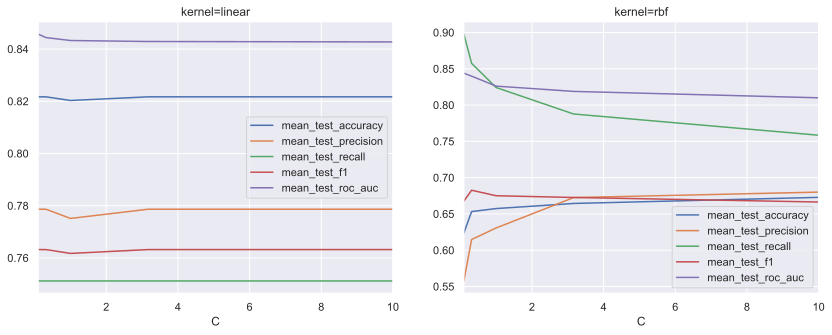

In [60]:
plot_grid_search_results_df(svm_gs_df, "C", "kernel", ["linear", "rbf"])

### Random Forest

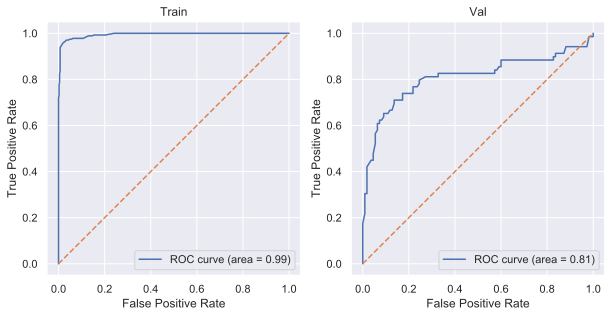

,Accuracy,Precision,Recall,F1,ROC AUC
Train,0.971910,0.984674,0.941392,0.962547,0.994435
Validation,0.765363,0.680000,0.739130,0.708333,0.808893
Train 5-fold CV (means),0.808949,0.775220,0.707003,0.736468,0.871521


In [61]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_estimators=100)
show_scores(rf_clf, show_roc_curves=True)

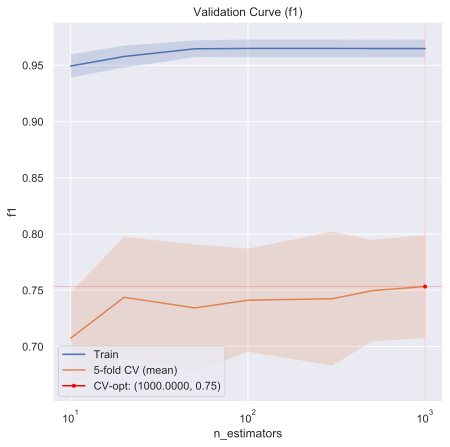

In [62]:
show_validation_curve(rf_clf, "n_estimators", [10, 20, 50, 100, 300, 500, 1000])

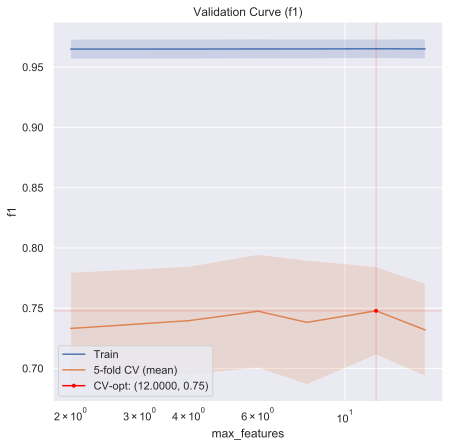

In [63]:
show_validation_curve(rf_clf, "max_features", [2, 4, 6, 8, 12, 16])

In [64]:
rf_clf_param_grid = {
     'max_depth' : [8, 12, 16],
     'n_estimators': [10, 30, 100, 300],
     'min_samples_split': [2, 3, 10],
     'min_samples_leaf': [1, 3, 10],
     'max_features': [6, 'sqrt', 'log2'],
     'bootstrap': [True, False],
     'criterion': ["gini", "entropy"]
}

rf_gs, rf_gs_df = grid_search(rf_clf, rf_clf_param_grid, n_jobs=-1, randomized=True, n_iter=100)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   30.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.3min finished


In [65]:
rf_gs_df.head(10)

,n_estimators,min_samples_split,min_samples_leaf,max_features,max_depth,criterion,bootstrap,mean_test_accuracy,mean_test_precision,mean_test_recall,mean_test_f1,mean_test_roc_auc
61,300,10,1,6,12,entropy,True,0.830066,0.814264,0.725387,0.762622,0.889687
55,30,10,1,log2,12,gini,True,0.824442,0.798358,0.729091,0.758678,0.887151
0,30,10,1,log2,8,gini,True,0.827239,0.812595,0.718114,0.757705,0.894116
38,10,3,10,sqrt,16,gini,True,0.825801,0.809404,0.718047,0.757438,0.874020
44,30,10,1,sqrt,8,entropy,False,0.822984,0.798988,0.725320,0.756998,0.873779
51,30,2,3,6,8,entropy,False,0.824442,0.802240,0.721684,0.756601,0.886473
29,300,2,1,6,12,gini,True,0.821635,0.796268,0.725387,0.755779,0.880563
10,30,10,1,6,8,gini,False,0.824442,0.807266,0.714343,0.754917,0.878718
8,100,2,1,6,16,entropy,True,0.820217,0.784055,0.732593,0.754600,0.878478
14,30,2,3,sqrt,12,gini,True,0.821665,0.798373,0.729158,0.754465,0.887639


In [66]:
rf_gs.best_params_

{'randomforestclassifier__n_estimators': 300,
 'randomforestclassifier__min_samples_split': 10,
 'randomforestclassifier__min_samples_leaf': 1,
 'randomforestclassifier__max_features': 6,
 'randomforestclassifier__max_depth': 12,
 'randomforestclassifier__criterion': 'entropy',
 'randomforestclassifier__bootstrap': True}

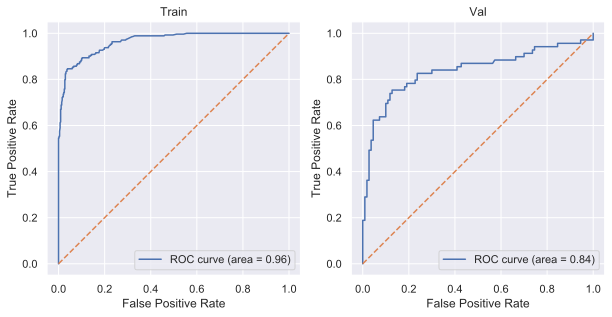

,Accuracy,Precision,Recall,F1,ROC AUC
Train,0.917135,0.934959,0.842491,0.886320,0.964697
Validation,0.821229,0.776119,0.753623,0.764706,0.838538
Train 5-fold CV (means),0.828648,0.825355,0.706936,0.756685,0.892398


In [67]:
show_scores(rf_gs.best_estimator_.named_steps["randomforestclassifier"], show_roc_curves=True)

#### Investigating Feature Importances

In [68]:
def feature_importances_df(rf):
    oh_array = rf.named_steps["pipeline"].named_steps["columntransformer"].named_transformers_["onehotencoding"].get_feature_names(input_features=one_hot_encoded_features)
    code_to_cat = rf.named_steps["pipeline"].named_steps["categoryencoder"].code_to_cat_
    
    clip_maps = rf.named_steps["pipeline"].named_steps["categorymaxclipper"].maps
    
    i = 0
    features = []
    for name in all_encoded_features:
        if i < len(oh_array) and oh_array[i].startswith(name):
            while i < len(oh_array) and oh_array[i].startswith(name):
                if name in code_to_cat:
                    features.append(oh_array[i][:-1] + code_to_cat[name][int(oh_array[i][-1])])
                elif name in clip_maps:
                    inv_map = {v: k for k, v in clip_maps[name].items()}
                    max_code = np.max(list(clip_maps[name].values()))
                    inv_map[max_code] = "REST"
                    features.append(oh_array[i][:-1] + inv_map[int(oh_array[i][-1])])
                else:
                    features.append(oh_array[i])
                i += 1
        else:
            features.append(name)
    
    feature_importances = rf.named_steps["randomforestclassifier"].feature_importances_
    return pd.DataFrame(zip(features, feature_importances), columns=["Feature", "Importance"]).sort_values(by="Importance", ascending=False)

def plot_feature_importances(rf, max_features=20):
    importances_df = feature_importances_df(rf)
    
    max_features = min(max_features, len(importances_df))
    importances_df = importances_df.iloc[:max_features]
    
    importances_df.set_index("Feature").plot(kind="barh", figsize=(8,8))
    plt.gca().invert_yaxis()

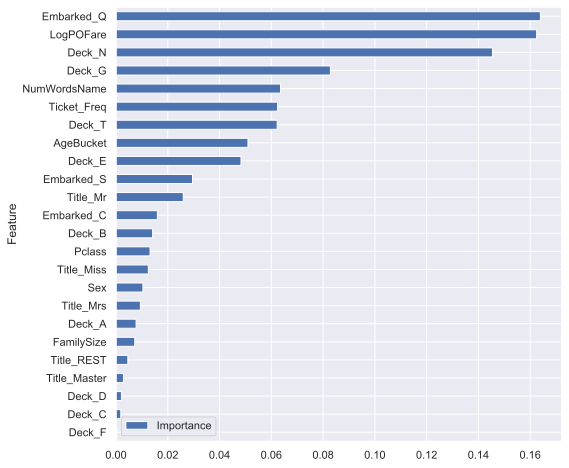

In [69]:
plot_feature_importances(rf_gs.best_estimator_, max_features=25)

### XGBoost

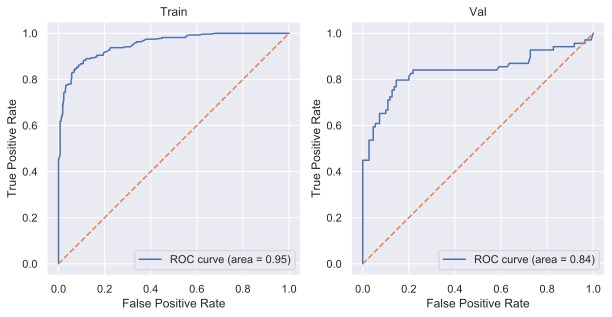

,Accuracy,Precision,Recall,F1,ROC AUC
Train,0.893258,0.898785,0.813187,0.853846,0.951709
Validation,0.826816,0.763889,0.797101,0.780142,0.836430
Train 5-fold CV (means),0.813284,0.786325,0.714411,0.742073,0.882640


In [70]:
from xgboost import XGBClassifier

xgb_clf = XGBClassifier()
show_scores(xgb_clf)

In [71]:
xgb_clf_params = {
    'min_child_weight': range(2, 8),
    'max_depth': range(2, 10),
    'gamma': [0.0, 0.1, 0.3, 0.9],
    'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree':[0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'reg_alpha': np.logspace(-5, 3, 5, endpoint=True),
    'reg_lambda': np.logspace(-3, 3, 5, endpoint=True),
    'learning_rate': [0.01, 0.1, 1]
}

xgb_gs, xgb_gs_df = grid_search(xgb_clf, xgb_clf_params, n_jobs=-1, randomized=True, n_iter=100)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   20.7s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   48.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   55.4s finished


In [72]:
xgb_gs_df.head()

,subsample,reg_lambda,reg_alpha,min_child_weight,max_depth,learning_rate,gamma,colsample_bytree,mean_test_accuracy,mean_test_precision,mean_test_recall,mean_test_f1,mean_test_roc_auc
25,0.9,31.6228,1e-05,3,3,0.01,0.1,0.5,0.828698,0.811309,0.721818,0.761018,0.865180
73,0.8,1,0.1,3,4,0.1,0.3,0.5,0.823123,0.792257,0.740135,0.757832,0.892393
44,0.8,31.6228,0.001,2,5,0.01,0.9,0.5,0.824462,0.801572,0.721818,0.756551,0.866519
83,0.5,0.001,10,2,6,1,0,0.6,0.809008,0.746168,0.765657,0.753741,0.869209
19,0.8,0.0316228,0.001,5,2,0.01,0.1,1,0.816021,0.781963,0.725455,0.749499,0.867055


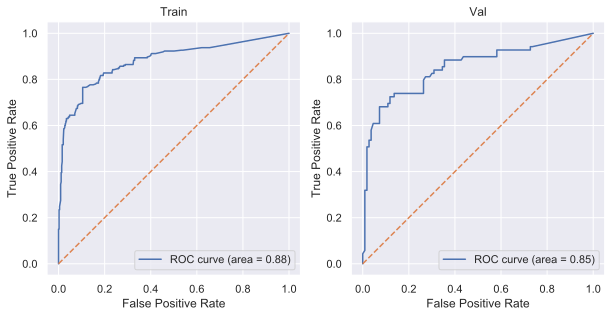

,Accuracy,Precision,Recall,F1,ROC AUC
Train,0.831461,0.812245,0.728938,0.768340,0.880339
Validation,0.815642,0.772727,0.739130,0.755556,0.851120
Train 5-fold CV (means),0.828698,0.811309,0.721818,0.761018,0.865180


In [73]:
show_scores(xgb_gs.best_estimator_.named_steps["xgbclassifier"], show_roc_curves=True)

In [83]:
xgb_gs.best_estimator_.score(X_val_raw, y_val)

0.8156424581005587

### Voting Classifier

In [76]:
from sklearn.ensemble import VotingClassifier

clf_list = [(str(x.best_estimator_.steps[-1][0]), x.best_estimator_) for x in [knn_gs, lr_gs, svm_gs, rf_gs, xgb_gs]]

v_clf = VotingClassifier(estimators=clf_list, voting="soft", n_jobs=-1)
v_clf.fit(X_raw, y_raw)

v_clf.score(X_raw, y_raw)

0.9090909090909091

In [84]:
v_clf.score(X_val_raw, y_val)

0.8491620111731844

## Testset Prediction
We'll use the voting classifier comprised of some of the best previous models to compute the final predictions for the testset:

In [78]:
y_test_pred = v_clf.predict(df_test_raw)

In [79]:
submission_data = pd.DataFrame({'Survived':y_test_pred}, index=df_test_raw.index)
submission_data.head()

,Survived
PassengerId,
892,0
893,1
894,0
895,0
896,1


In [81]:
submission_data.to_csv("./local_data/titanic/test_predictions.csv")